In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Measles/benin.csv')
data.head()


,Year-Month,Cases
0,2011-1,21
1,2011-2,36
2,2011-3,49
3,2011-4,71
4,2011-5,50


In [4]:
data.shape

(159, 2)

In [5]:
data.columns

Index(['Year-Month', 'Cases'], dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Year-Month  159 non-null    object
 1   Cases       159 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


In [7]:
data.describe()

,Cases
count,159.00
mean,31.86
std,43.07
min,0.00
25%,3.50
50%,16.00
75%,39.00
max,266.00


In [8]:
data['Date'] = pd.to_datetime(data['Year-Month'])
data = data.drop(columns = 'Year-Month')
data = data.set_index('Date')
data = data.rename(columns = {'Cases':'Cases'})
data.head()

,Cases
Date,
2011-01-01,21
2011-02-01,36
2011-03-01,49
2011-04-01,71
2011-05-01,50


In [9]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [10]:
def tsplot(y, lags=24, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

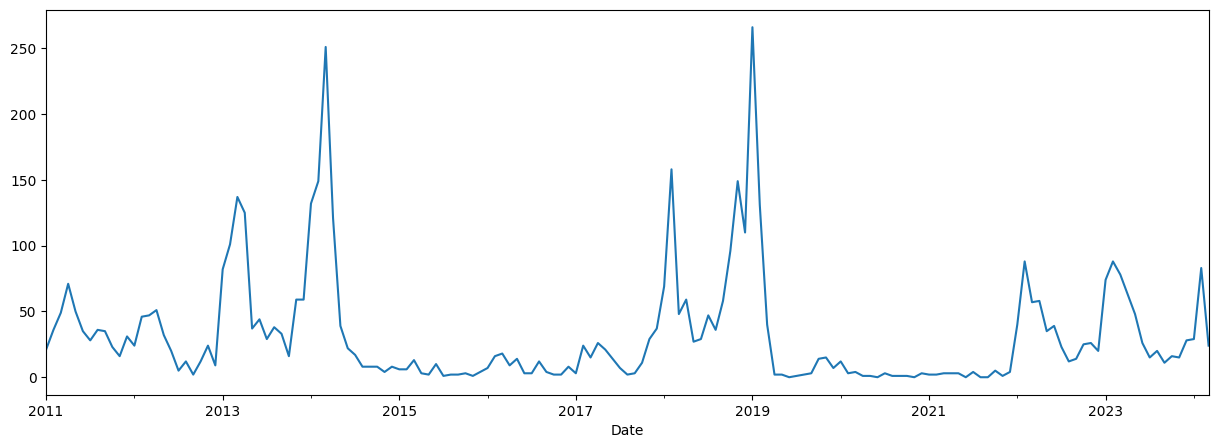

In [11]:
plt.figure(figsize = (15,5))
data['Cases'].plot();

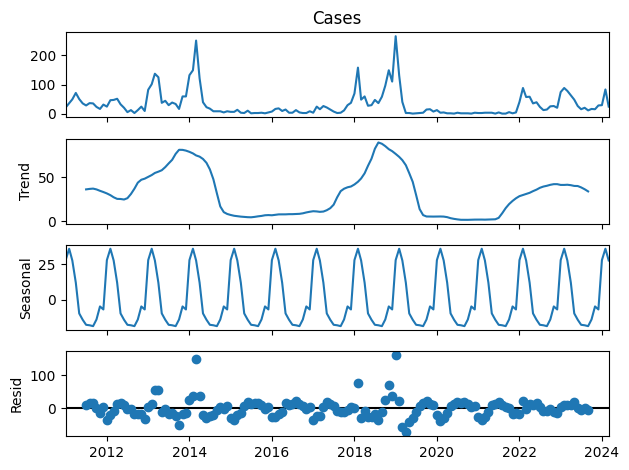

In [13]:
decomposition = sm.tsa.seasonal_decompose(data['Cases'],period = 12, model = 'additive').plot() #model='multiplicative' 0 değerimiz olduğu için kullanamayız
plt.show()

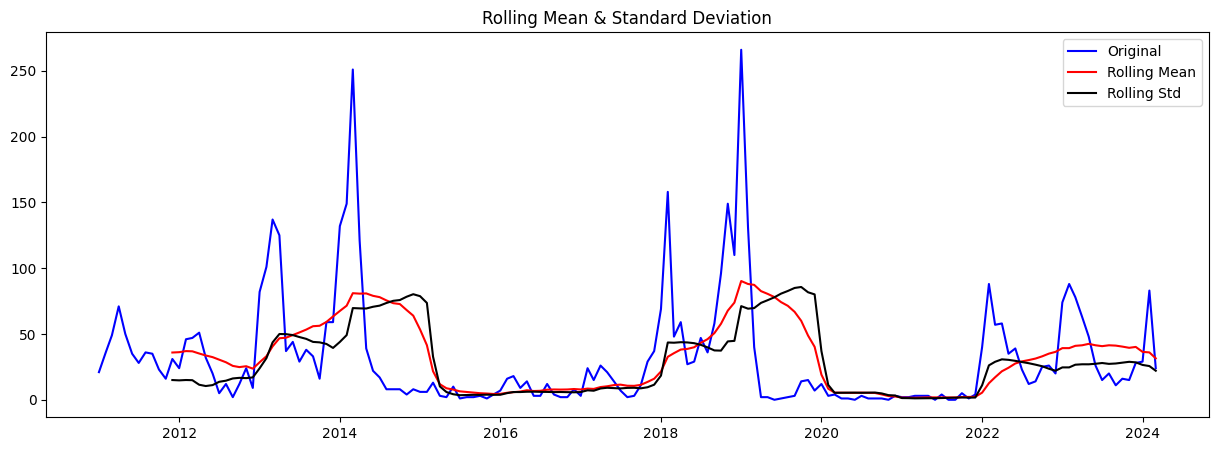

Results of Dickey-Fuller Test:
Test Statistic                 -3.08
p-value                         0.03
#Lags Used                     12.00
Number of Observations Used   146.00
Critical Value (1%)            -3.48
Critical Value (5%)            -2.88
Critical Value (10%)           -2.58
dtype: float64


In [14]:
test_stationarity(data['Cases'])

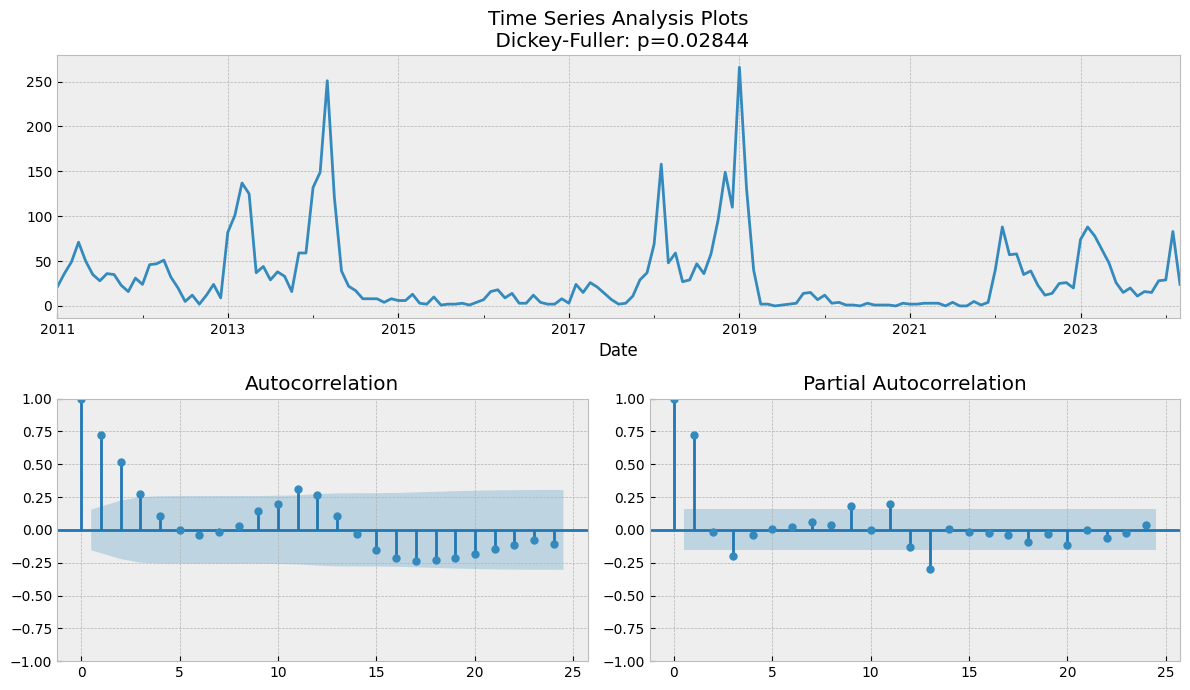

In [15]:
tsplot(data['Cases'])

In [16]:
import numpy as np
from statsmodels.tsa.stattools import kpss


# Perform KPSS test
kpss_stat, p_value, lags, critical_values = kpss(data['Cases'])

# Print the results
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Critical Values: {critical_values}')

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis: The series is not stationary.")
else:
    print("Fail to reject the null hypothesis: The series is stationary.")

KPSS Statistic: 0.11934016474014277
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Fail to reject the null hypothesis: The series is stationary.


<ipython-input-16-a7f5dbdcd447>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, critical_values = kpss(data['Cases'])


In [18]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.2 MB/s eta 0:00:00


In [21]:
train = data.iloc[0:147]
test = data.iloc[147:]

In [25]:
import pmdarima as pm
stepwise_fit = pm.auto_arima(train["Cases"],
                          d=0, D=0, m=0, trend=None, seasonal=None,
                          start_p=0, start_q=0, max_order=15, test='adf',
                          stepwise=False, trace=True)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1594.866, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1508.627, Time=0.11 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1465.688, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1448.725, Time=0.20 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=1439.623, Time=0.29 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=1440.213, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1432.018, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1433.960, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1432.797, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1434.784, Time=0.26 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1434.720, Time=0.49 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=1.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1433.941, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1435.063, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1434.787, Time=0.24 sec
 ARIMA(2,0,3)(0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  147
Model:               SARIMAX(4, 0, 2)   Log Likelihood                -707.070
Date:                Fri, 19 Jul 2024   AIC                           1428.140
Time:                        07:32:06   BIC                           1449.073
Sample:                    01-01-2011   HQIC                          1436.645
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.3333      0.238      9.798      0.000       1.867       2.800
ar.L2         -1.8080      0.450     -4.018      0.000      -2.690      -0.926
ar.L3          0.2585      0.277      0.932      0.352      -0.285       0.802
ar.L4          0.1965      0.081      2.414      0.016       0.037       0.356
ma.L1         -1.6012      0.266     -6.022      0.000      -2.122      -1.080
ma.L2          0.7692      0.271      2.835      0.005       0.237       1.301
sigma2       871.3758     64.508     13.508      0.000     744.942     997.809
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               480.09
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

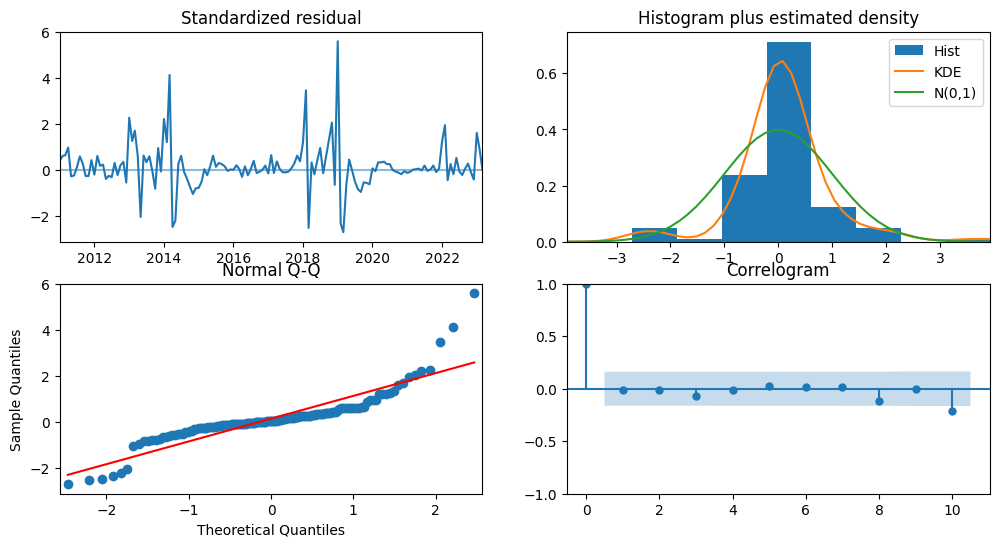

In [27]:
display(stepwise_fit.summary())
stepwise_fit.plot_diagnostics(figsize=(12,6));

In [28]:
model = ARIMA(train["Cases"],order = (3,0,4))
model = model.fit()
model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Us

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Cases   No. Observations:                  147
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -704.959
Date:                Fri, 19 Jul 2024   AIC                           1427.919
Time:                        07:32:28   BIC                           1454.832
Sample:                    01-01-2011   HQIC                          1438.854
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.9262     13.035      2.449      0.014       6.378      57.474
ar.L1          1.6789      0.880      1.907      0.057      -0.047       3.405
ar.L2         -1.1263      1.368     -0.824      0.410      -3.807       1.554
ar.L3          0.1784      0.686      0.260      0.795      -1.166       1.523
ma.L1         -0.9792      0.875     -1.119      0.263      -2.694       0.736
ma.L2          0.5677      0.787      0.721      0.471      -0.975       2.111
ma.L3         -0.0560      0.284     -0.197      0.844      -0.613       0.501
ma.L4          0.1945      0.193      1.007      0.314      -0.184       0.573
sigma2       843.0550     73.938     11.402      0.000     698.140     987.970
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               758.00
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             2.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
lags = list(range(0, 13))

In [35]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results = acorr_ljungbox(model.resid, lags=lags, return_df=True)
print(ljung_box_results)

    lb_stat  lb_pvalue
0     21.13        NaN
1      0.06       0.80
2      0.14       0.93
3      0.23       0.97
4      0.23       0.99
5      0.41       1.00
6      1.26       0.97
7      2.07       0.96
8      2.11       0.98
9      3.60       0.94
10     7.20       0.71
11    15.03       0.18
12    21.13       0.05


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

error = model.resid
acorr = acorr_ljungbox(error)
print(acorr)

    lb_stat  lb_pvalue
1      0.06       0.80
2      0.14       0.93
3      0.23       0.97
4      0.23       0.99
5      0.41       1.00
6      1.26       0.97
7      2.07       0.96
8      2.11       0.98
9      3.60       0.94
10     7.20       0.71


In [36]:
prd = model.forecast(steps=len(test))
prd

2023-04-01   63.47
2023-05-01   49.65
2023-06-01   39.02
2023-07-01   29.18
2023-08-01   22.49
2023-09-01   20.44
2023-10-01   22.78
2023-11-01   27.83
2023-12-01   33.29
2024-01-01   37.21
2024-02-01   38.52
2024-03-01   37.29
Freq: MS, Name: predicted_mean, dtype: float64

<ipython-input-46-7b58eff885ff>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = prd


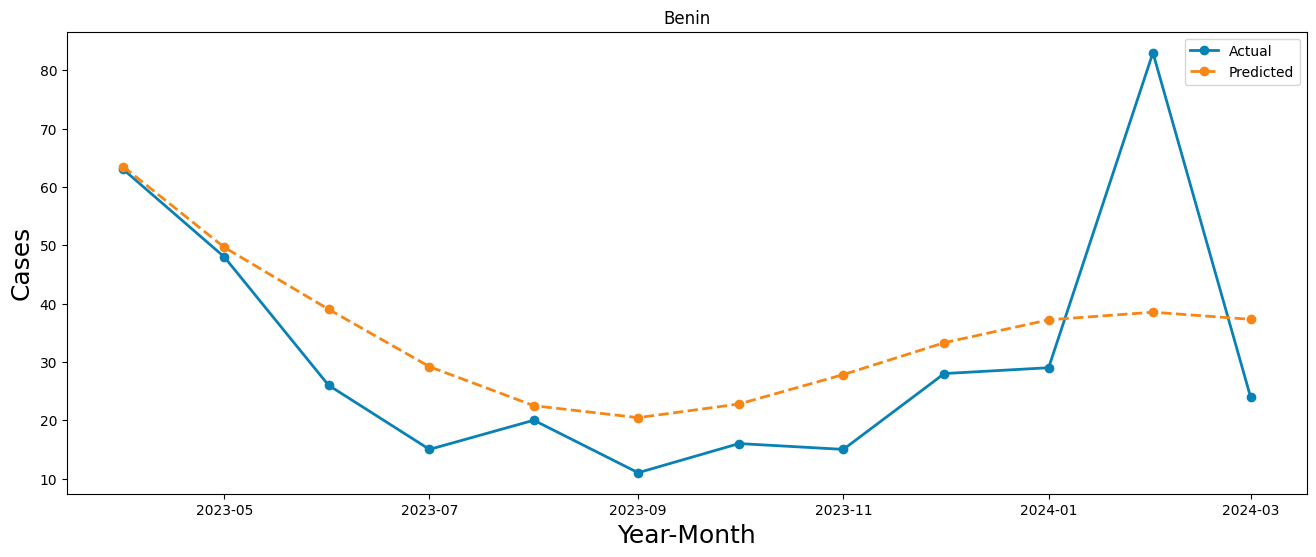

In [46]:
# Plot the data
valid = data[147:]
valid['Predictions'] = prd
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Benin')
plt.xlabel('Year-Month', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.plot(valid['Cases'], color='#0981b5', marker='o',linewidth=2)  # Actual cases
plt.plot(valid['Predictions'], color='#f78614',marker='o', linestyle='--',linewidth=2)  # Predicted cases (dashed line)
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(test["Cases"],prd))
print('Test RMSE: %.4f' % error)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test["Cases"],prd)
print("Mean Absolute Error (MAE):", mae)

from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(test["Cases"],prd)
print("Mean Squared Logarithmic Error (MSLE):", msle)



def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(test["Cases"], prd)
print(f"MAPE: {mape:.2f}%")

Test RMSE: 15.6259
Mean Absolute Error (MAE): 11.011419558239055
Mean Squared Logarithmic Error (MSLE): 0.18372121761900817
MAPE: 44.27%
